In [11]:
library(terra)
library(sf)
library(tidyterra)
library(MultiscaleDTM)
library(randomForest)
library(caret)
library(vip)
library(rstac)
library(whitebox)
library(tmap)


s_obj <- stac("https://planetarycomputer.microsoft.com/api/stac/v1")

ERROR: Error in library(tmap): there is no package called ‘tmap’


In [4]:
wa_dem_prj <- rast("data/wa_dem_diss_prj3740.tif")

In [5]:
wa_dem_prj

class       : SpatRaster 
dimensions  : 24499, 30003, 1  (nrow, ncol, nlyr)
resolution  : 23.64304, 23.64304  (x, y)
extent      : 342358, 1051720, 4982935, 5562166  (xmin, xmax, ymin, ymax)
coord. ref. : NAD83(HARN) / UTM zone 10N (EPSG:3740) 
source      : wa_dem_diss_prj3740.tif 
name        : NASADEM_HGT_n49w125 
min value   :           -35.65501 
max value   :          4373.03906 

In [6]:
wa_slp_3 <-rast("data/wa_slope3.tif")

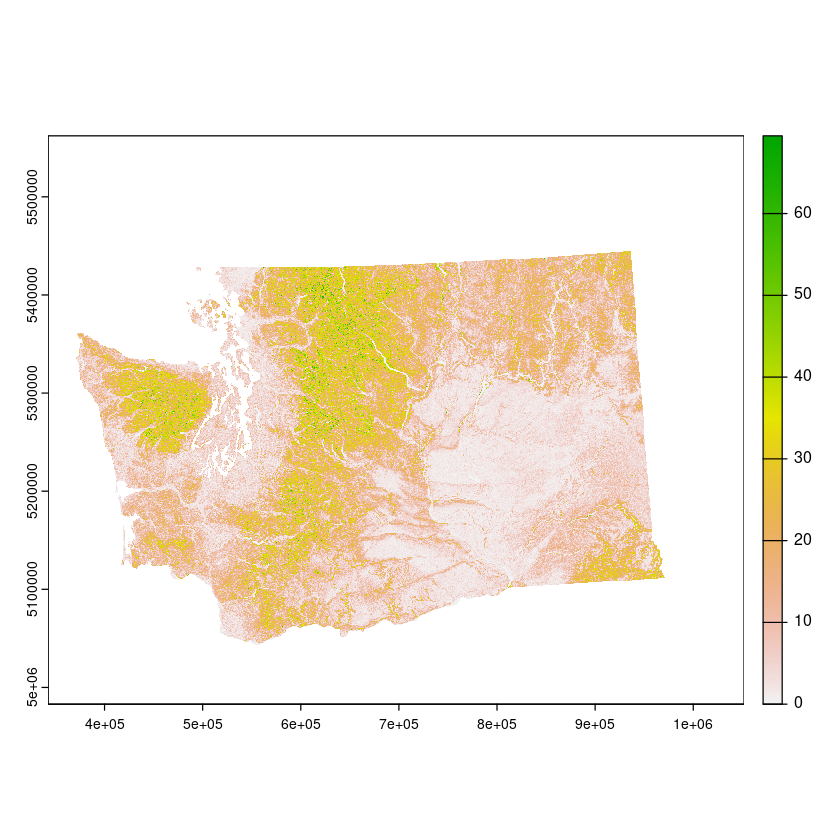

In [9]:
plot(wa_slp_3$slope)

In [14]:
# wa_slp_27 <- MultiscaleDTM::SlpAsp(wa_dem_prj, w = c(27, 27), 
#                                    filename = "data/wa_slope27.tif", overwrite = T)

In [16]:
wa_slp_27 <- rast("data/wa_slope27.tif")

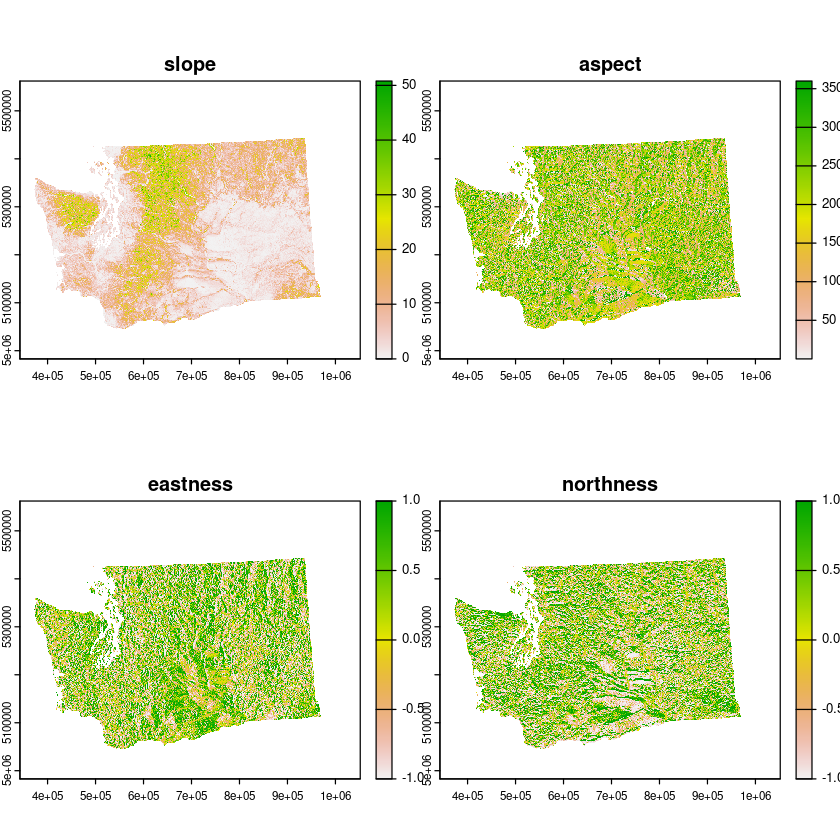

In [19]:
plot(wa_slp_27)

In [ ]:
wa_slp_81 <- MultiscaleDTM::SlpAsp(wa_dem_prj, w = c(81, 81), metrics = c("slope"),
                                   filename = "data/wa_slope81.tif", overwrite = T)